In [236]:
# import ocean row module
from mod_ocean_row import ocean_row

In [257]:
# # reload package
# import importlib
# import mod_ocean_row
# importlib.reload(mod_ocean_row)
# from mod_ocean_row import ocean_row

# 1.1 Model configurations

In [4]:
# create dictionary of starting location
# Dsloc = {'start_name':'Fremantle'    ,'start_lat':-32.056946,'start_lon':115.743889}
# Dsloc = {'start_name':'Geraldton'    ,'start_lat':-28.782387,'start_lon':114.607513} 
Dsloc = {'start_name':'Kalbarri'     ,'start_lat':-27.711053,'start_lon':114.164536} 
# Dsloc = {'start_name':'Carnarvon'    ,'start_lat':-24.883717,'start_lon':113.656956} 
# Dsloc = {'start_name':'Exmouth'      ,'start_lat':-21.930724,'start_lon':114.122389} 
# Dsloc = {'start_name':'Broome'       ,'start_lat':-17.951221,'start_lon':122.244327} 

# create dictionary of destination location
Deloc = {'stop_name':'Dar es Salaam' ,'stop_lat':-6.766305  ,'stop_lon':39.195973  } # create dictionary of destination location

# date and time
tod_0     = '2018-05-01 03:00:00' # starting datetime
tod_start = ['06:00:00','14:00:00'] # start rowing [time of day]
tod_stop  = ['12:00:00','20:00:00'] # stop rowing [time of day]
Dtime     = {'tod_0':tod_0,'tod_start':tod_start,'tod_stop':tod_stop} # create dictionary

# rowing properties
m     = 670 # wiegth [kg]

# convert m/s to kts
tokts = 1.94384449 # convert m/s to kts

# rowing speed perfect conditions
vperf = 1.7/tokts # boat velocity in perfect conditions [m/s]

# water friction - boat
rhow  = 1024 # density water [kg/m^3]
Aw    = 15 # frontal area exposed to water
Cdw   = 0.005 # friction coef. water 
Gw    = rhow*Cdw*Aw/2 # water friction constant

# water friction - anchor
GwA   = 50*Gw # water friction constant sea anchor

# friction ratio boat
G     = .01 # ratio of air friction cosntant to water friction constant (Ga/Gw)

# air friction 
Ga    = G*Gw # air friction constant

Drow_prop = {'m':m,'vperf':vperf,'Gw':Gw,'GwA':GwA,'Ga':Ga} # create dictionary of all rowing properties

# combine all configurations
mcf = Dsloc | Deloc | Drow_prop | Dtime # model configuration (as dictionary)
mcf # print all configuration options

{'start_name': 'Kalbarri',
 'start_lat': -27.711053,
 'start_lon': 114.164536,
 'stop_name': 'Dar es Salaam',
 'stop_lat': -6.766305,
 'stop_lon': 39.195973,
 'm': 670,
 'vperf': 0.8745555566536086,
 'Gw': 38.4,
 'GwA': 1920.0,
 'Ga': 0.384,
 'tod_0': '2018-05-01 03:00:00',
 'tod_start': ['06:00:00', '14:00:00'],
 'tod_stop': ['12:00:00', '20:00:00']}

# 1.2 Hindcast data

In [140]:
import xarray as xr

# air velocity (wind)
dsa0 = xr.open_dataset( r'C:\Users\23513098\OneDrive - The University of Western Australia\Documents\Rick\Work\RIOP\Scripts\Data\CERSAT-GLO-REP_WIND_L4-OBS_FULL_TIME_SERIE_1648775425193.nc').load()
dsa  = xr.Dataset(
    data_vars=dict(
        # correct wind dataset (wrong direction of winds)
        ua  = (["time", "lat", "lon"], dsa0.eastward_wind.isel(depth=0).values),
        va  = (["time", "lat", "lon"], dsa0.northward_wind.isel(depth=0).values)),
    coords=dict(
        lon  = dsa0.longitude.values,
        lat  = dsa0.latitude.values,
        time = dsa0.time.values))

# water velocity (currents)
dsw0 = xr.open_dataset( r'C:\Users\23513098\OneDrive - The University of Western Australia\Documents\Rick\Work\RIOP\Scripts\Data\nemo_monthly_mean.nc').load()
dsw  = xr.Dataset(
    data_vars=dict(
        uw  = (["time", "lat", "lon"], dsw0.uo.isel(depth=0).values),
        vw  = (["time", "lat", "lon"], dsw0.vo.isel(depth=0).values),
        Tw  = (["time", "lat", "lon"], dsw0.thetao.isel(depth=0).values)),
    coords=dict(
        lon  = dsw0.longitude.values,
        lat  = dsw0.latitude.values,
        time = dsw0.time.values))

# wave heights 
dswh0 = xr.open_dataset(r'C:\Users\23513098\OneDrive - The University of Western Australia\Documents\Rick\Work\RIOP\Scripts\Data/cmems_obs-wave_glo_phy-swh_my_multi-l4-2deg_P1D_1648776708969.nc').load()
dswh  = xr.Dataset(
    data_vars=dict(
        # correct wind dataset (wrong direction of winds)
        H_day_mean = (["time", "lat", "lon"], dswh0.VAVH_DAILY_MEAN.values),
        H_day_max  = (["time", "lat", "lon"], dswh0.VAVH_DAILY_MAX.values)),
    coords=dict(
        lon  = dswh0.longitude.values,
        lat  = dswh0.latitude.values,
        time = dswh0.time.values))

hc = {'dsa':dsa,'dsw':dsw,'dswh':dswh} # create single dictonary of all datasets
del dsa0,dsa,dsw0,dsw,dswh0,dswh
hc

{'dsa': <xarray.Dataset>
 Dimensions:  (time: 163, lat: 129, lon: 348)
 Coordinates:
   * lon      (lon) float32 30.12 30.38 30.62 30.88 ... 116.1 116.4 116.6 116.9
   * lat      (lat) float32 -31.88 -31.62 -31.38 -31.12 ... -0.375 -0.125 0.125
   * time     (time) datetime64[ns] 2007-05-01T12:00:00 ... 2020-12-01T12:00:00
 Data variables:
     ua       (time, lat, lon) float32 1.83 1.67 1.65 1.65 ... nan nan nan nan
     va       (time, lat, lon) float32 -1.41 -1.19 -1.28 -1.4 ... nan nan nan nan,
 'dsw': <xarray.Dataset>
 Dimensions:  (time: 329, lat: 385, lon: 1045)
 Coordinates:
   * lon      (lon) float32 30.0 30.08 30.17 30.25 ... 116.8 116.8 116.9 117.0
   * lat      (lat) float32 -32.0 -31.92 -31.83 -31.75 ... -0.1667 -0.08333 0.0
   * time     (time) datetime64[ns] 1993-01-16T12:00:00 ... 2020-05-16T12:00:00
 Data variables:
     uw       (time, lat, lon) float32 -0.7434 -0.7093 -0.661 ... nan nan nan
     vw       (time, lat, lon) float32 -0.8533 -0.802 -0.7465 ... nan nan na

# 1.3 Previous ocean rows

In [141]:
import pandas as pd
import numpy as np
import geopandas as gpd
from datetime import datetime
import re
from   geographiclib.geodesic      import Geodesic

# Load data of ocean row Sarah Outen
kml_file = r"C:\Users\23513098\OneDrive - The University of Western Australia\Documents\Rick\Work\RIOP\Scripts\Data\Track_Sarah_Outen.kml" # file directory

gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw' # configure kml reader 
df = gpd.read_file(kml_file, driver='KML') # read kml file
x  = df.geometry.x.values # set longitude values
y  = df.geometry.y.values # set latitude values
t  = pd.Series([datetime.strptime(re.search(r'\d{2}/\d{2}/\d{4} \d{2}:\d{2}:\d{2}', x).group(), '%d/%m/%Y %H:%M:%S') for x in df.Description]) # create time series

dfS = pd.DataFrame({'datet':t,'lon':x,'lat':y}) # store in dataframe
dfS = dfS.sort_values(by=['datet']).reset_index(drop=True) # sort by time

# Load data of ocean row Erden Eruc
tab     = pd.read_csv(r'C:\Users\23513098\OneDrive - The University of Western Australia\Documents\Rick\Work\RIOP\Scripts\Data\Track_Erden_Eruc.csv',encoding= 'unicode_escape') # file directory
tstring = [x[x.find('-')+2:x.find('(')-1]+' '+x[x.find('(')+1:x.find(')')-4] for x in tab['Day/Date']] # get time as string
tstring = [x.replace('\xa0',' ') for x in tstring] # clean up time strings
t       = pd.to_datetime(tstring) # convert to datetime

# convert latitude 
deg       = np.array([re.split('[::]', x)[0] for x in tab.Latitude.values.astype(str)]).astype(int)
minutes   = np.array([re.split('[::]', x)[1] for x in tab.Latitude.values.astype(str)]).astype(int)
seconds   = np.array([re.split('[::]', x)[2][:-1] for x in tab.Latitude.values.astype(str)]).astype(int)
direction = np.array([re.split('[::]', x)[2][-1] for x in tab.Latitude.values.astype(str)]).astype(str)
y         = (deg + minutes/60 + seconds/(60*60)) * np.array([(-1 if x in ['W', 'S'] else 1) for x in direction])

# convert longitude 
deg       = np.array([re.split('[::]', x)[0] for x in tab.Longitude.values.astype(str)]).astype(int)
minutes   = np.array([re.split('[::]', x)[1] for x in tab.Longitude.values.astype(str)]).astype(int)
seconds   = np.array([re.split('[::]', x)[2][:-1] for x in tab.Longitude.values.astype(str)]).astype(int)
direction = np.array([re.split('[::]', x)[2][-1] for x in tab.Longitude.values.astype(str)]).astype(str)
x         = (deg + minutes/60 + seconds/(60*60)) * np.array([(-1 if x in ['W', 'S'] else 1) for x in direction])

dfE = pd.DataFrame({'datet':t,'lon':x,'lat':y}) # store in dataframe
dfE = dfE.sort_values(by=['datet']).reset_index(drop=True) # sort by time

# calculate average boat speed
for df in [dfS,dfE]:
    N  = len(df) # number of data points
    ub = np.empty(N) # allocate boat speed longitudinal ub
    vb = np.empty(N) # allocate boat speed lateral vb
    for i in range(N-1): 
        geo_data = Geodesic.WGS84.Inverse(df.lat[i],df.lon[i],df.lat[i+1],df.lon[i+1]) # get geo data between points
        ds = geo_data['s12'] # distance between points
        dy = ds*np.cos(geo_data['azi1']/180*np.pi) # lateral distance per step (in m)
        dx = ds*np.sin(geo_data['azi1']/180*np.pi) # longitudinal distance per step (in m)
        dt = (df.datet[i+1]-df.datet[i])/np.timedelta64(1, 's') # time step (in s)
        ub[i] = dx/dt # boat speed longitudinal
        vb[i] = dy/dt # boat speed lateral
    ub[N-1] = np.nan # no boat speed for last point
    vb[N-1] = np.nan 
    df['ub'] = ub # include in dataframe
    df['vb'] = vb

# include water (current) and air (wind) speeds to dataframes of previous rows
for df in [dfS,dfE]: # loop over dataframes
    N = len(df) # number of data poitns
    
    # allocate speeds
    ua = np.empty(N) # longitudinal air
    va = np.empty(N) # lateral air
    uw = np.empty(N) # longitudinal water
    vw = np.empty(N) # lateral water

    for i in range(N):
        datet = np.array(df.datet[i]).astype('datetime64[s]')
        lon = df.lon[i]
        lat = df.lat[i]
        X = np.array([[lon,lat]])

        # datasets
        dsa = hc['dsa']
        dsw = hc['dsw']
        
        # dataset coordinates
        dsa_time = dsa.time.values
        dsa_lon  = dsa.lon.values
        dsa_lat  = dsa.lat.values
        dsw_time = dsw.time.values
        dsw_lon  = dsw.lon.values
        dsw_lat  = dsw.lat.values
        
        Va,Vw = ocean_row.get_hindcast_at_loc(X,datet,dsa,dsw,dsa_time,dsa_lon,dsa_lat,dsw_time,dsw_lon,dsw_lat)
        uw[i] = Vw[0,0]
        vw[i] = Vw[0,1]
        ua[i] = Va[0,0]
        va[i] = Va[0,1]
        
    # add to dataframe
    df['uw'] = uw
    df['vw'] = vw
    df['ua'] = ua
    df['va'] = va

In [142]:
dfS

,datet,lon,lat,ub,vb,uw,vw,ua,va
0,2009-04-01 00:10:45,115.741112,-32.060280,-0.466145,0.687981,-0.034181,0.070193,-3.74,5.00
1,2009-04-02 00:11:11,115.316948,-31.523335,-0.763080,0.515845,0.036012,-0.098880,-3.76,5.22
2,2009-04-03 03:10:41,114.540001,-31.068890,-0.611600,-0.094643,0.095828,-0.183721,-3.75,6.35
3,2009-04-04 00:10:27,114.055283,-31.132502,-0.467788,0.287482,0.080569,0.069582,-3.93,6.22
4,2009-04-05 00:10:26,113.632500,-30.907778,-0.448703,0.084727,0.209967,0.117801,-4.30,6.59
...,...,...,...,...,...,...,...,...,...
121,2009-07-31 00:12:46,60.877500,-21.186944,-0.949959,0.077099,-0.182501,-0.006714,-7.60,3.11
122,2009-08-01 00:05:01,60.091667,-21.125278,-0.876382,0.378224,-0.117191,-0.068361,-7.58,2.78
123,2009-08-02 00:43:41,59.344722,-20.820556,-1.253545,0.179288,-0.093387,-0.110477,-7.50,2.69
124,2009-08-03 00:43:37,58.305278,-20.677500,0.000000,0.000000,-0.054323,-0.052492,-7.44,2.41


In [143]:
dfE

,datet,lon,lat,ub,vb,uw,vw,ua,va
0,2010-07-13 03:50:00,113.651944,-24.896944,-0.831628,0.492963,-0.074465,0.120853,-3.27,5.26
1,2010-07-14 04:00:00,112.938056,-24.508056,-0.729513,-0.009121,-0.054933,-0.144047,-3.99,5.27
2,2010-07-15 04:00:00,112.316111,-24.513889,-0.454500,-1.035572,-0.274056,-0.600604,-3.97,5.43
3,2010-07-16 04:00:00,111.926111,-25.321111,-0.567326,0.591598,-0.193487,-0.429701,-2.91,5.25
4,2010-07-17 04:00:00,111.441111,-24.858889,-0.474382,0.546657,-0.160527,-0.126957,-2.83,3.81
...,...,...,...,...,...,...,...,...,...
132,2010-11-22 04:00:00,46.595000,-14.490000,-0.056057,-0.453202,0.106204,0.054323,0.70,-0.83
133,2010-11-23 04:00:00,46.550000,-14.843889,-0.321145,-0.270546,-0.061037,-0.065310,1.43,-1.07
134,2010-11-24 04:00:00,46.291944,-15.055000,0.026233,-0.405906,-0.092166,-0.070193,1.65,-0.83
135,2010-11-25 04:00:00,46.313056,-15.371944,-0.031038,-0.236933,-0.119022,-0.053102,1.65,-1.05


# 2.1 overview
Create the following plots:

* Allowed rowing domain and shortest distance between starting point and destination
* Rowing interval as a function of time 
* Plot rowing speed as a function of the parallel wind speed (no waves and currents)
* Monthly average of hindcast data

C:\Users\23513098\Anaconda3\lib\site-packages\descartes\patch.py:63: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  concatenate([asarray(t.exterior)[:, :2]] +
C:\Users\23513098\Anaconda3\lib\site-packages\descartes\patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])


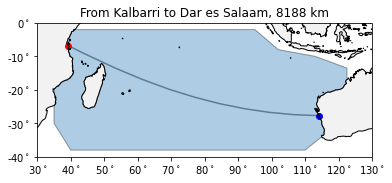

In [144]:
# plot shortest distance between starting point and destination. In addition, plot the allowed rowing domain
fig,ax = ocean_row(mcf).plt_overview()

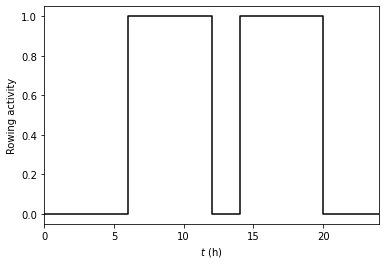

In [145]:
# plot rowing interval as a function of time (0 = resting, 1 = rowing)
fig,ax = ocean_row(mcf).plt_rowing_activity()

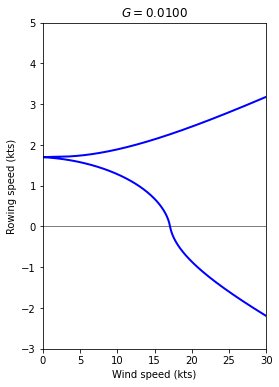

In [146]:
# plot rowing speed as a function of the parallel wind speed (no waves and currents)
fig,ax = ocean_row(mcf).plt_vrow_wind_only()

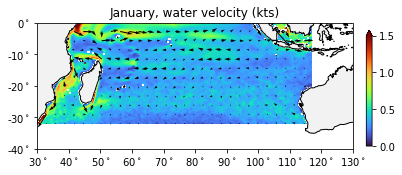

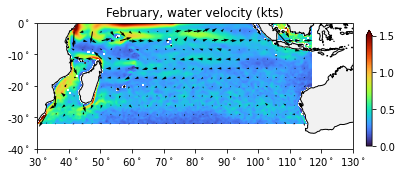

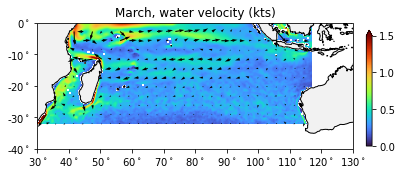

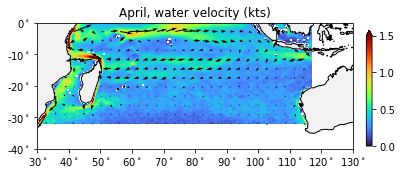

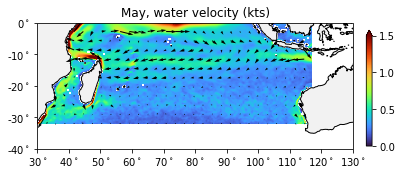

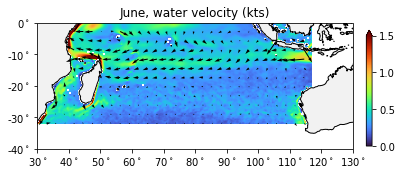

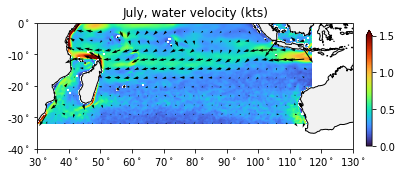

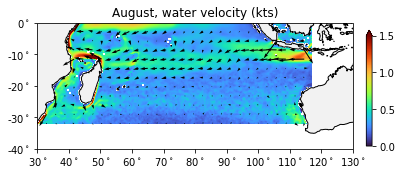

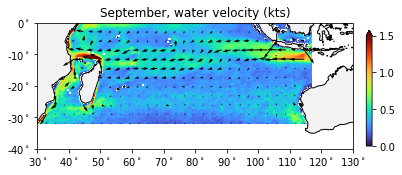

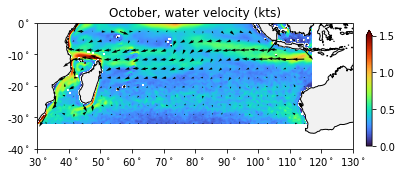

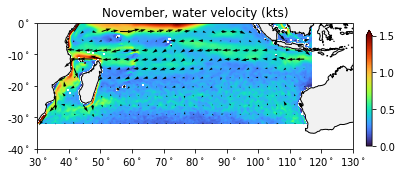

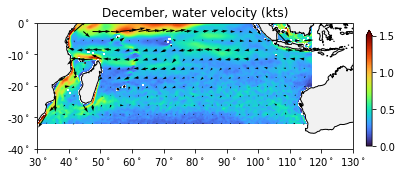

In [150]:
# monthly average of hindcast data
# ocean_row.plt_hindcast(hc,'air velocity') # air velocity
ocean_row.plt_hindcast(hc,'water velocity') # water velocity 
# ocean_row.plt_hindcast(hc,'water temperature') # water temperature
# ocean_row.plt_hindcast(hc,'daily wave height mean') # wave height mean
# ocean_row.plt_hindcast(hc,'daily wave height max') # wave height max 

<IPython.core.display.Javascript object>


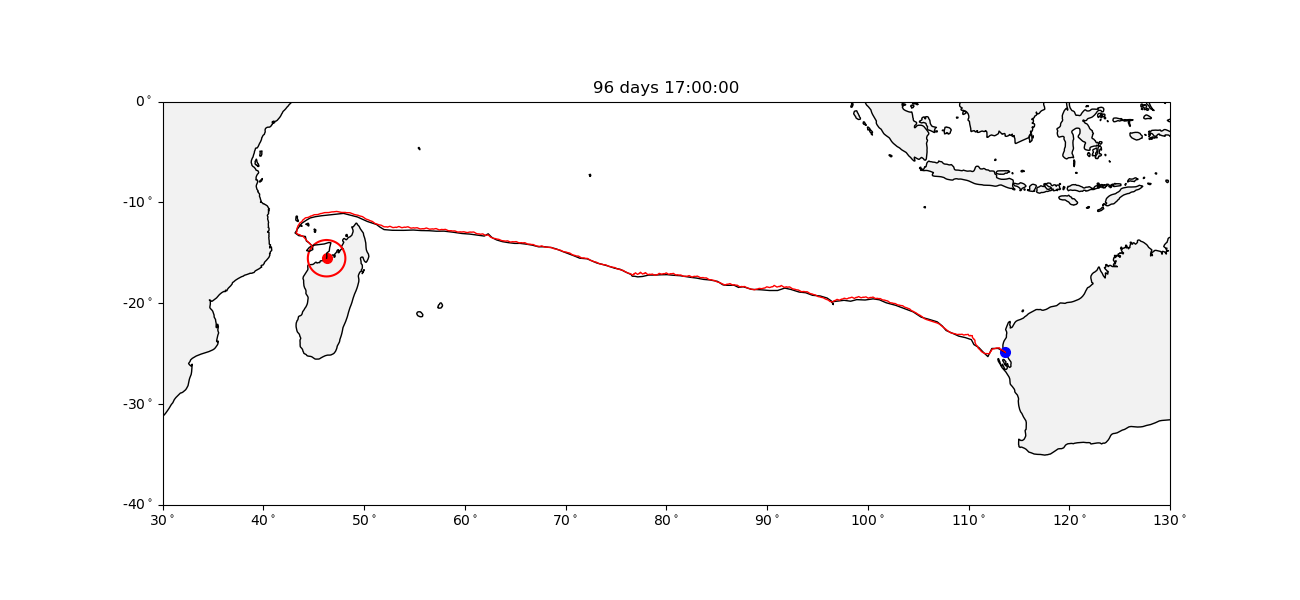

In [259]:
imax  = 700 # maximum number of iterations
rtmin = 200000 # minimum distance till target

# # case 1: row in direction of destination
# dmode = {'mode':'destination','anchor_drop':False,'filters_on':False}

# # case 2: optimization
# dmode = {'mode':'optimize','angle_max':90,'angle_Nstep':5,'Np':50}

# case 3: follow GPS
df        = dfE.copy() # load in dataframe
Xa_pr     = np.stack([df.lon,df.lat]).T # track locations
tod_0_pr  = str(df.datet[0]) # string of datetime to start row (optional)
datets_pr = df.datet.to_numpy()
dmode     = {'mode':'track','Xa_pr':Xa_pr,'tod_0':tod_0_pr,'anchor_drop':False,'filters_on':False}


%matplotlib notebook
Xs,Vas,Vws,Vs,datets,Nhists,Ns = ocean_row(mcf).run_ocean_row(hc,dmode,imax,rtmin)
%matplotlib inline

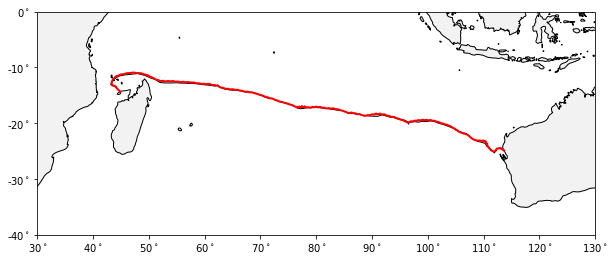

In [260]:
import matplotlib.pyplot as plt

ocean_row(mcf).plt_base_simple([30,130],[-40,0],10,10)
plt.gcf().set_size_inches(10,10)

N = Nhists.shape[0]

if dmode['mode']=='optimize':
    plt.scatter(Xs.reshape([-1,2])[:,0],Xs.reshape([-1,2])[:,1],0.1,color='b') # plot all possible routes
        
if dmode['mode']=='track':
    plt.plot(Xa_pr[:,0],Xa_pr[:,1],'k-',linewidth=1) # plot followed GPS track
    
Xf = ocean_row(mcf).get_fastest_route(Nhists,Xs) # get fastest route
plt.plot(Xf[:,0],Xf[:,1],'r-',linewidth=2) # plot fastest route
plt.show()

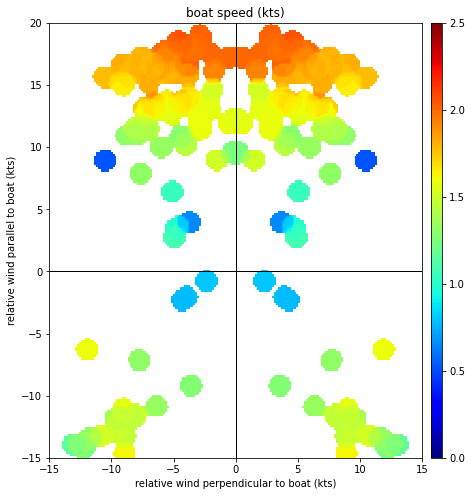

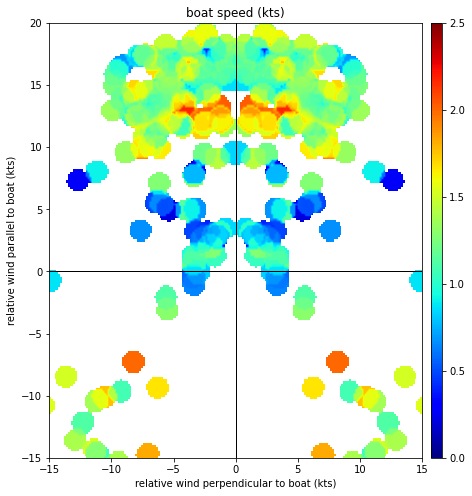

In [261]:
# plot polor plot
# set plot limits
xlims = [-15,15]
ylims = [-15,20]
zlims = [0,2.5]

# model rpw
# sample model row to daily
_,iday  = np.unique(datets.astype('datetime64[D]'),return_index=True) # get index of first timestamp of day

if dmode['mode'] == 'optimize':
    Xf  = ocean_row(mcf).get_fastest_route(Nhists,Xs) # get fastest route
    Xac = Xf[iday,:]
else:
    Xac = Xs[iday,0,:] # get locations
datetsc = datets[iday] # get timestamps

ocean_row.coords_to_polar(Xac,datetsc,hc,xlims=xlims,ylims=ylims,zlims=zlims) # model row

if dmode['mode']=='track': # compare to polar plot of track
    ocean_row.coords_to_polar(Xa_pr,datets_pr,hc,xlims=xlims,ylims=ylims,zlims=zlims) # previous row